In [7]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # activation functions
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

### Create Fully Connected Neural Network

In [8]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes): # input_size=28*28=784
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, 50) # 50 hidden layer nodes
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### Create simple CNN

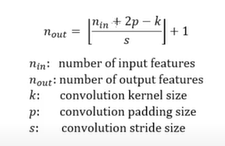

In [9]:
class CNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super(CNN, self).__init__()
    self.con1 = nn.Conv2d(in_channels=in_channels, 
                          out_channels=8, # cnn features 
                          kernel_size=(3,3), 
                          stride=(1,1), 
                          padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.con2 = nn.Conv2d(in_channels=8, 
                          out_channels=16, # cnn features 
                          kernel_size=(3,3), 
                          stride=(1,1), 
                          padding=(1,1))
    self.fc1 = nn.Linear(16*7*7, num_classes) # 28 will be divided (halfed) twice becz we'll use pooling twice

  def forward(self, x):
    x = F.relu(self.con1(x))
    x = self.pool(x)
    x = F.relu(self.con2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc1(x)

    return x


### Initialize Device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize Hyperparameters

In [16]:
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

### Load Data with DataLoader

In [12]:
train_dataset = datasets.MNIST(root='dataset/', 
                               train=True, 
                               transform=transforms.ToTensor(), 
                               download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', 
                               train=False, 
                               transform=transforms.ToTensor(), 
                               download=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Initialize the model

In [13]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

### Loss & Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Remember to give model parameters here

### Training the Model

In [17]:
for epoch in tqdm(range(num_epochs)):
  for ind, (data, target) in enumerate(train_loader):
    data = data.to(device=device)
    target = target.to(device=device)
    
    # forward
    scores = model(data)
    loss = criterion(scores, target)

    # backward
    optimizer.zero_grad() # set all the gradients to 0 for each batch
    loss.backward()

    # gradient descent or adam step - updates the parameters
    optimizer.step()

  print(f"Epoch {epoch+1} is done")

 20%|██        | 1/5 [00:18<01:12, 18.25s/it]

Epoch 1 is done


 40%|████      | 2/5 [00:36<00:54, 18.27s/it]

Epoch 2 is done


 60%|██████    | 3/5 [00:54<00:36, 18.29s/it]

Epoch 3 is done


 80%|████████  | 4/5 [01:13<00:18, 18.29s/it]

Epoch 4 is done


100%|██████████| 5/5 [01:31<00:00, 18.29s/it]

Epoch 5 is done


### Testing the Model

In [18]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval() # Let the model know that this is evaluation mode

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)

      scores = model(x)
      
      # Which class has the max value
      _, pred = scores.max(dim=1)
      num_correct += (pred == y).sum()
      num_samples += pred.size(0) # 64

    print(f"Got {num_correct} / {num_samples} with accuracy {(float(num_correct)/float(num_samples)*100):.2f}%")

In [19]:
check_accuracy(test_loader, model)

Got 9849 / 10000 with accuracy 98.49%
